<a href="https://colab.research.google.com/github/fadelmuli/wmh-seg-unet/blob/main/Brain_White_Matter_Hyperintensities_Segmentation_With_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES AND FUNCTIONS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library

In [ ]:
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
import matplotlib.pyplot as plt
import nibabel
from glob import glob
import timeit

K.set_image_data_format('channels_last')

## Functions

### Loading Dataset

In [ ]:
def create_train_data():
    
    training_masks = sorted(glob('/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold*/wmh*'))
    del training_masks[-1]
    print(training_masks)


    training_images = sorted(glob('/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold*/flair*'))
    del training_images[-1]
    print(training_images)
    training_icvs = sorted(glob('/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold*/icv*'))
    
    imgs_train = [] 
    masks_train = [] 
    icv_train = []


    for wmh, orig, icv in zip(training_masks, training_images, training_icvs):
        training_mask = nibabel.load(wmh)
        training_image = nibabel.load(orig)
        training_icv = nibabel.load(icv)
        for k in range(training_mask.shape[2]):
            mask_2d = np.array(training_mask.get_fdata()[:, :, k])
            image_2d = np.array(training_image.get_fdata()[:, :, k])
            icv_2d = np.array(training_icv.get_fdata()[:,:,k])
            
            
            # Hanya memasukkan slice otak yang memiliki WMH agar mengurangi data imbalance
            if len(np.unique(mask_2d)) != 1:
                masks_train.append(mask_2d)
                imgs_train.append(image_2d)
                icv_train.append(icv_2d)
                    
    imgs_orig = np.array(imgs_train)
    imgs_mask = np.array(masks_train)
    imgs_icv = np.array(icv_train)
    
    return imgs_orig, imgs_mask, imgs_icv


def create_test_data():
    
    images = glob('/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold4/*')   
    imgs_test = []
    masks_test = []
    icvs_test = []
    
    for image_name in images:
        print(image_name)
        img = nibabel.load(image_name)
        print(img.shape)
        
        for k in range(img.shape[2]):              
            if 'wmh' in image_name:
                img_2d = np.array(img.get_fdata()[:, :, k])
                masks_test.append(img_2d)
            
            elif 'flair' in image_name:
                img_2d = np.array(img.get_fdata()[:, :, k])
                imgs_test.append(img_2d)
            
            elif 'icv' in image_name:
                img_2d = np.array(img.get_fdata()[:, :, k])
                icvs_test.append(img_2d)
                
    test_orig = np.array(imgs_test)
    test_mask = np.array(masks_test)
    test_icv = np.array(icvs_test)
    return test_orig, test_mask, test_icv

### Dice Similarity Coefficient (DSC) for loss and metrics

In [ ]:
#   CODE CREDIT: Marko Jocić
#   https://github.com/jocicmarko/ultrasound-nerve-segmentation

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### Building U-Net Model

In [ ]:
#   CODE CREDIT: Marko Jocić
#   https://github.com/jocicmarko/ultrasound-nerve-segmentation

def get_unet(input_shape =(256,256,1)):
    inputs = Input((input_shape))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

# PREPROCESSING

## Load training and validation data training

In [ ]:
imgs_train_init, masks_train_init, icvs_train_init = create_train_data()

# Gaussian normalization
imgs_train_init -= np.mean(imgs_train_init[icvs_train_init == 1])
imgs_train_init /= np.std(imgs_train_init[icvs_train_init == 1])

imgs_list = []
mask_list = []

# Image cropping & uniform sizing
for k in range(imgs_train_init.shape[0]):
    cropped_img = imgs_train_init[k][np.ix_(icvs_train_init[k].any(1), icvs_train_init[k].any(0))]
    cropped_mask = masks_train_init[k][np.ix_(icvs_train_init[k].any(1), icvs_train_init[k].any(0))]
    imgs_list.append(resize(cropped_img, (256, 256), preserve_range=True))
    mask_list.append(resize(cropped_mask, (256, 256), preserve_range=True))

imgs_train = np.array(imgs_list)
masks_train = np.array(mask_list)
imgs_train = imgs_train[..., np.newaxis]
masks_train = masks_train[..., np.newaxis]

['/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold1/wmh_label.nii.gz', '/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold2/wmh_label.nii.gz', '/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold3/wmh_label.nii.gz']
['/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold1/flair.nii.gz', '/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold2/flair.nii.gz', '/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold3/flair.nii.gz']


## Load testing data

In [ ]:
imgs_test_init, masks_test_init, icvs_test_init = create_test_data()

# Gaussian normalization
imgs_test_init -= np.mean(imgs_test_init[icvs_test_init == 1])
imgs_test_init /= np.std(imgs_test_init[icvs_test_init == 1])

imgst_list = []
maskt_list = []

# Image cropping & uniform sizing
for k in range(imgs_test_init.shape[0]):
    cropped_img = imgs_test_init[k][np.ix_(icvs_test_init[k].any(1), icvs_test_init[k].any(0))]
    cropped_mask = masks_test_init[k][np.ix_(icvs_test_init[k].any(1), icvs_test_init[k].any(0))]
    imgst_list.append(resize(cropped_img, (256, 256), preserve_range=True))
    maskt_list.append(resize(cropped_mask, (256, 256), preserve_range=True))

imgs_test = np.array(imgst_list)
masks_test = np.array(maskt_list)

/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold4/flair.nii.gz
(256, 256, 421)
/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold4/icv.nii.gz
(256, 256, 421)
/content/drive/MyDrive/Colab Notebooks/IP/Tugas Akhir/ADNI_20x3_2015/fold4/wmh_label.nii.gz
(256, 256, 421)


### Sebelum vs sesudah preprocessing

Text(0.5, -0.15, '(b). Setelah preprocessing')

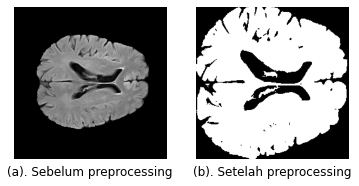

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(imgs_train_init[312,:,:], cmap='gray')
plt.axis('off')
plt.title('(a). Sebelum preprocessing', y=-0.15)
plt.subplot(1,2,2)
plt.imshow(np.invert(np.uint(imgs_train[312,:,:,0])), cmap='gray')
plt.axis('off')
plt.title('(b). Setelah preprocessing', y=-0.15)

# TRAINING AND EVALUATION

In [ ]:
model = get_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
start = timeit.default_timer()

# Training
model = get_unet()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', verbose=1, save_best_only=True)

history=model.fit(imgs_train, masks_train, batch_size=64, epochs=80, verbose=1, shuffle=True, 
                  validation_split=0.2, callbacks=[model_checkpoint])

stop = timeit.default_timer()
time_train = stop - start
print('Time: ' + str(time_train))

Epoch 1/80
9/9 [==============================] - 12s 1s/step - loss: -0.0087 - dice_coef: 0.0087 - val_loss: -0.0199 - val_dice_coef: 0.0316

Epoch 00001: val_loss improved from inf to -0.01990, saving model to weights.h5
Epoch 2/80
9/9 [==============================] - 11s 1s/step - loss: -0.0097 - dice_coef: 0.0097 - val_loss: -0.0219 - val_dice_coef: 0.0348

Epoch 00002: val_loss improved from -0.01990 to -0.02190, saving model to weights.h5
Epoch 3/80
9/9 [==============================] - 11s 1s/step - loss: -0.0110 - dice_coef: 0.0110 - val_loss: -0.0256 - val_dice_coef: 0.0409

Epoch 00003: val_loss improved from -0.02190 to -0.02562, saving model to weights.h5
Epoch 4/80
9/9 [==============================] - 11s 1s/step - loss: -0.0130 - dice_coef: 0.0131 - val_loss: -0.0323 - val_dice_coef: 0.0541

Epoch 00004: val_loss improved from -0.02562 to -0.03234, saving model to weights.h5
Epoch 5/80
9/9 [==============================] - 11s 1s/step - loss: -0.0184 - dice_coef: 0.

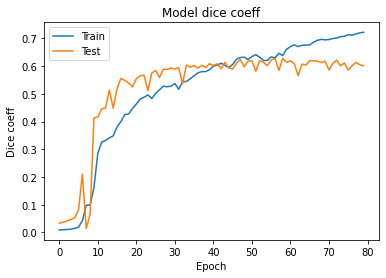

In [ ]:
# Plot DSC per epoch

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('history_plot.png')
plt.show()

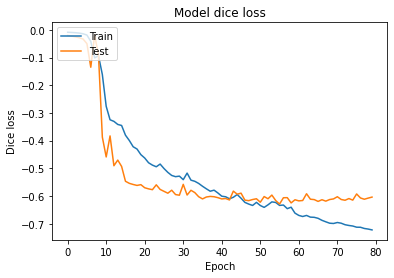

In [ ]:
# Plot Dice Loss per epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model dice loss')
plt.ylabel('Dice loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss_plot.png')
plt.show()

# TESTING

### Evaluate the model with DSC

In [ ]:
start = timeit.default_timer()

model = get_unet()

model.load_weights('weights.h5')
res = model.evaluate(imgs_test, masks_test, batch_size=64)

7/7 [==============================] - 5s 638ms/step - loss: -0.4439 - dice_coef: 0.4462


### Segment all the slices with the trained model

In [ ]:
pred_test = model.predict(imgs_test, verbose=1, batch_size=64)


7/7 [==============================] - 2s 363ms/step


### 10 slice sample test

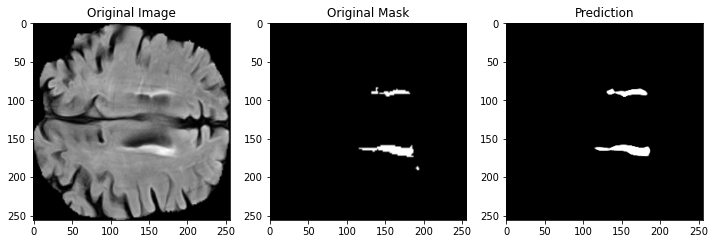

DSC: 0.8424978


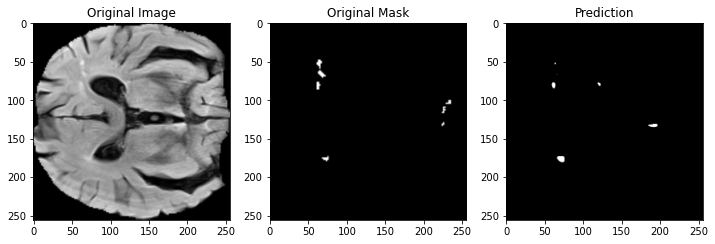

DSC: 0.30850476


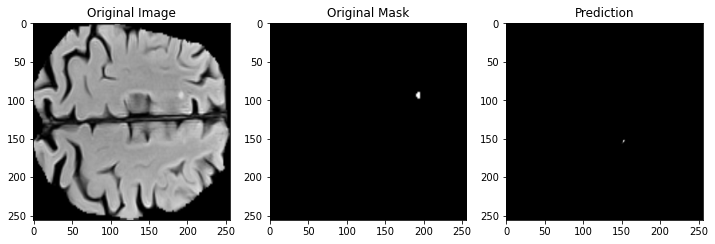

DSC: 0.025067417


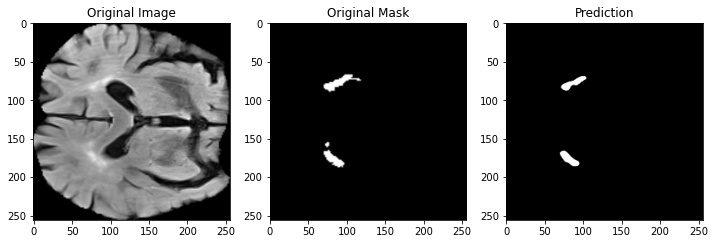

DSC: 0.8064203


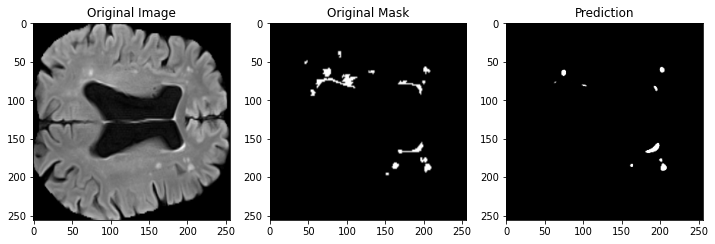

DSC: 0.40515596


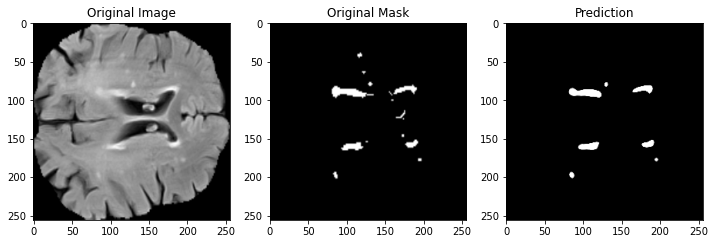

DSC: 0.77657044


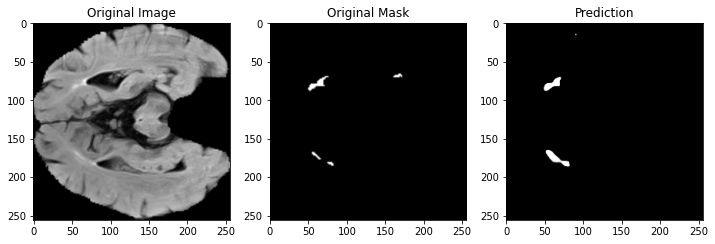

DSC: 0.6183951


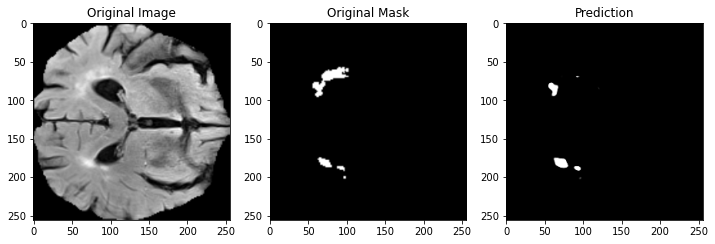

DSC: 0.51891595


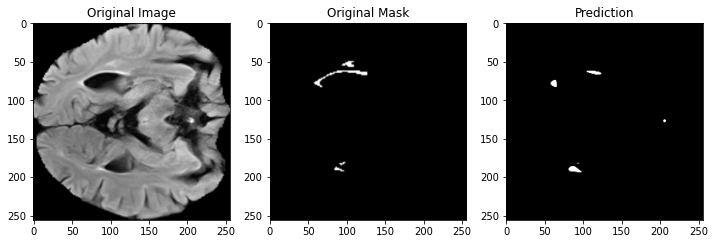

DSC: 0.46904126


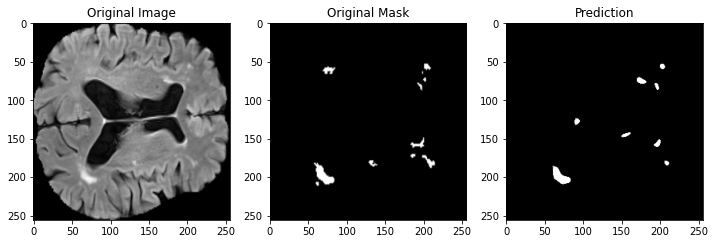

DSC: 0.56872714
Mean DSC (10 samples): 0.53392965


In [ ]:
slices = [413, 151, 303, 379, 242, 45, 92, 407, 178, 212]
test_sample = imgs_test[slices, :, :]

sample_dscs = []
for index in slices:   
    
    # Visual comparison of ground truth vs U-Net
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(imgs_test[index], cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(masks_test[index], cmap='gray')
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow((pred_test[index][:,:,0]), cmap='gray')
    plt.title('Prediction')
    plt.show()
    
    # DSC
    dsc = dice_coef(K.constant(masks_test[index,:,:]), K.constant(pred_test[index,:,:,0])).numpy()
    print('DSC: ' + str(dsc))
    sample_dscs.append(dsc)


# Mean DSC
print('Mean DSC (10 samples): ' + str(np.mean(sample_dscs)))

In [ ]:
stop = timeit.default_timer()

print(stop-start)

11.215174380000008


### 30 random segment result slices

7/7 [==============================] - 2s 359ms/step
Slice ID: 87


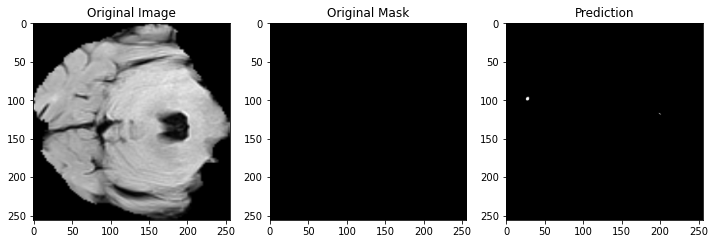

Slice ID: 76


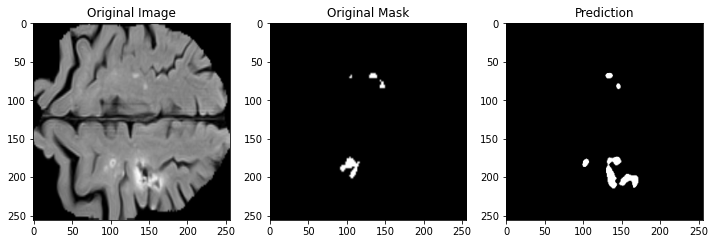

Slice ID: 116


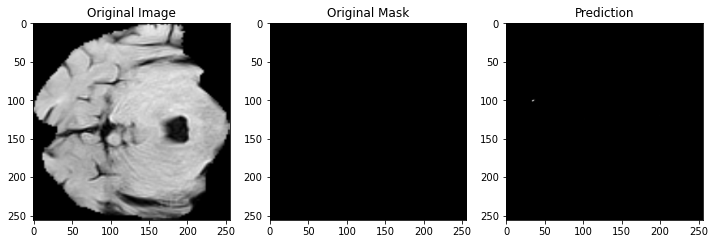

Slice ID: 229


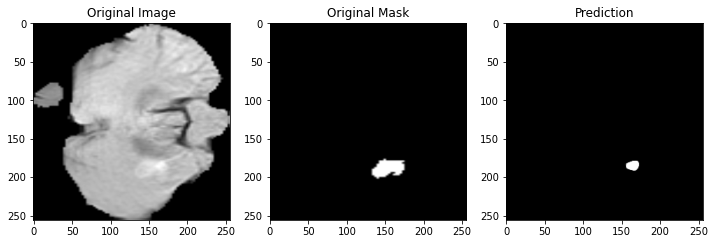

Slice ID: 222


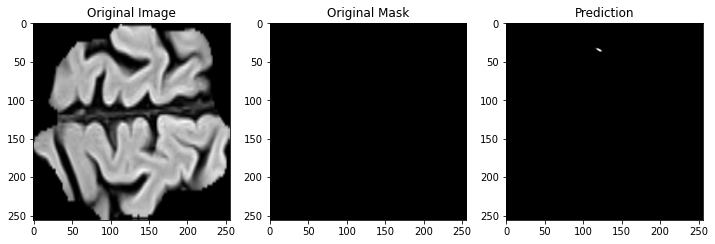

Slice ID: 348


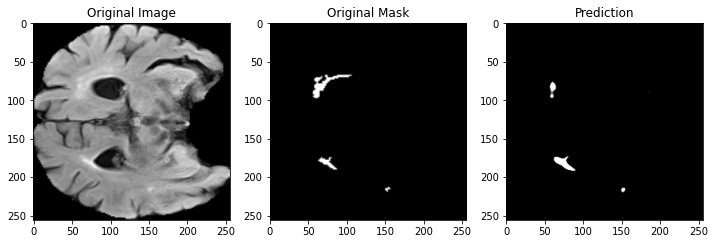

Slice ID: 222


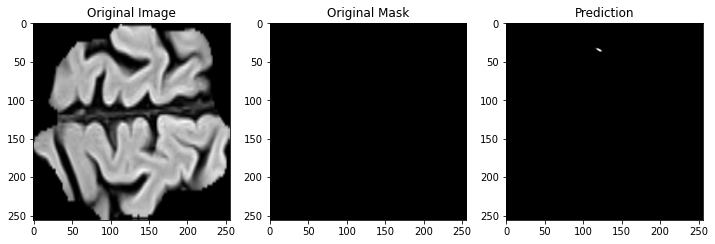

Slice ID: 58


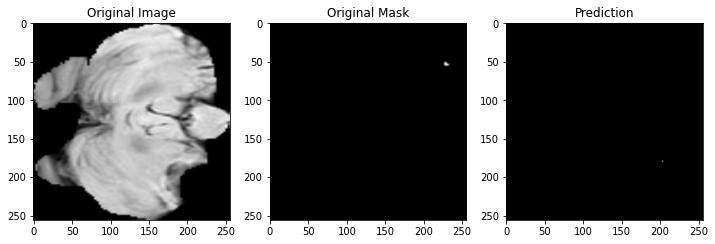

Slice ID: 98


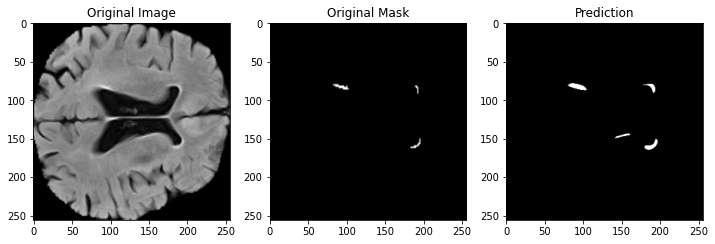

Slice ID: 341


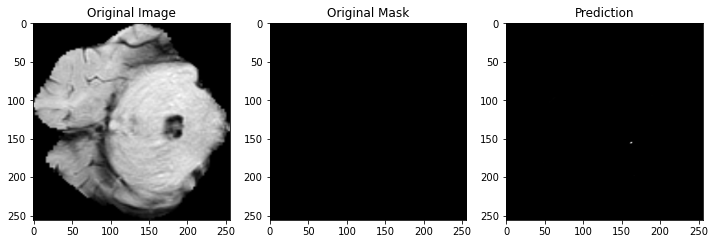

Slice ID: 385


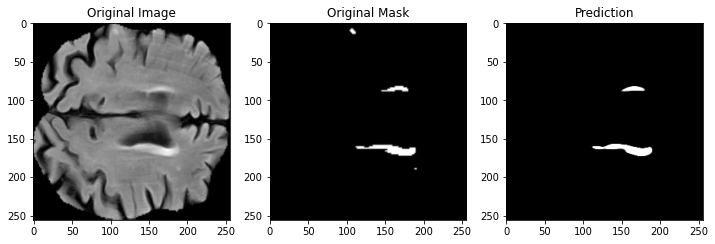

Slice ID: 407


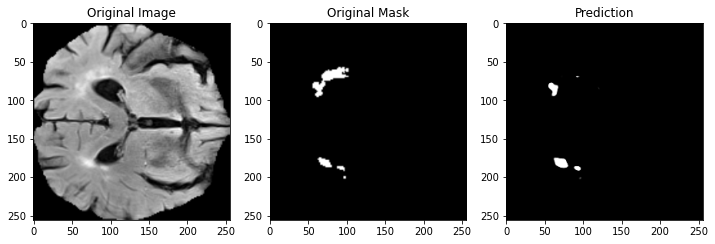

Slice ID: 184


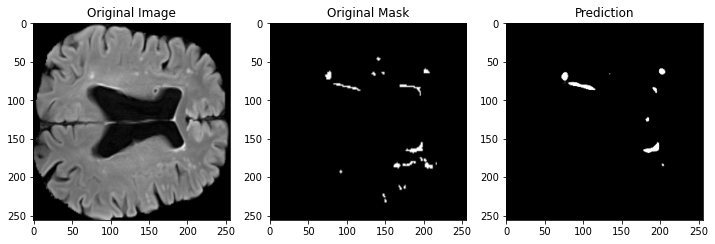

Slice ID: 123


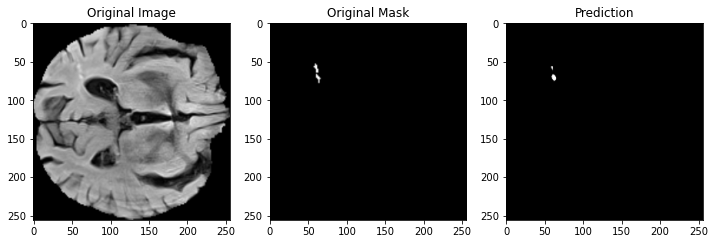

Slice ID: 281


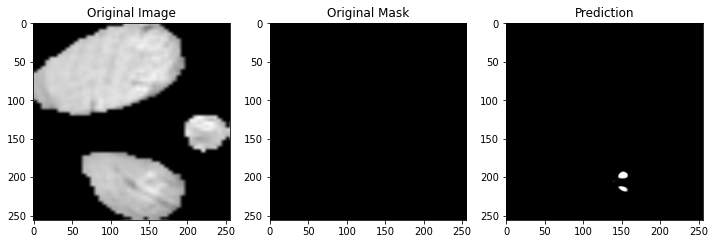

Slice ID: 173


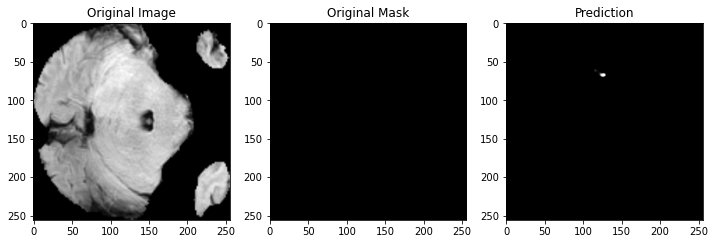

Slice ID: 40


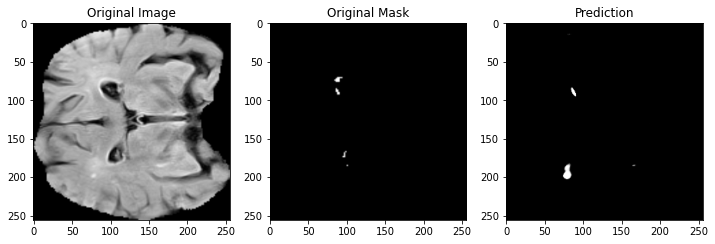

Slice ID: 234


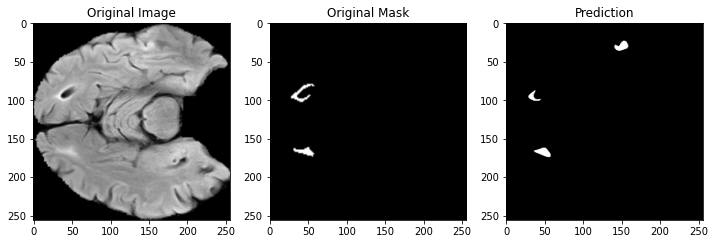

Slice ID: 291


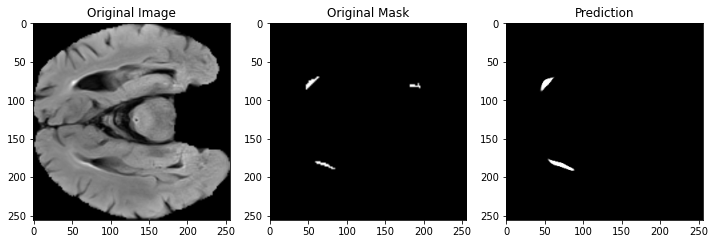

Slice ID: 294


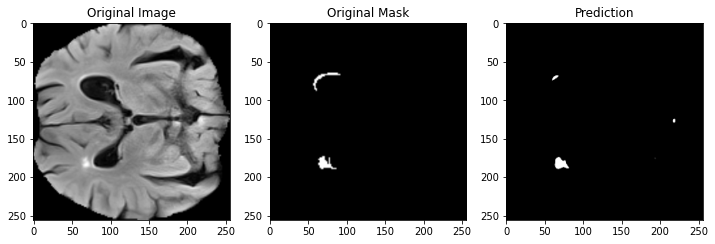

Slice ID: 287


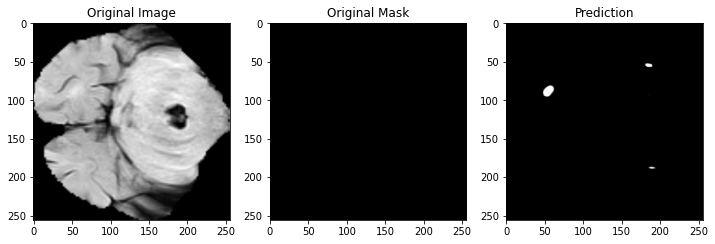

Slice ID: 25


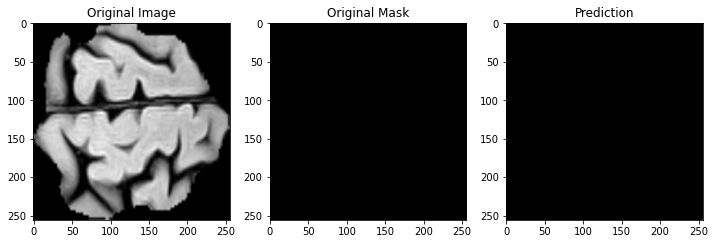

Slice ID: 241


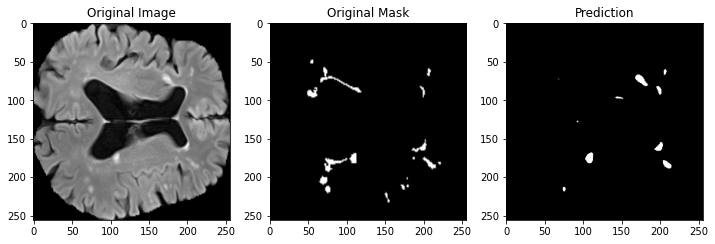

Slice ID: 103


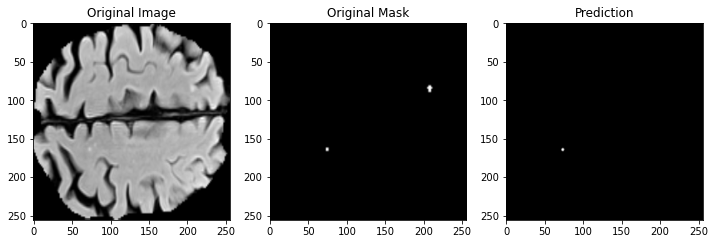

Slice ID: 326


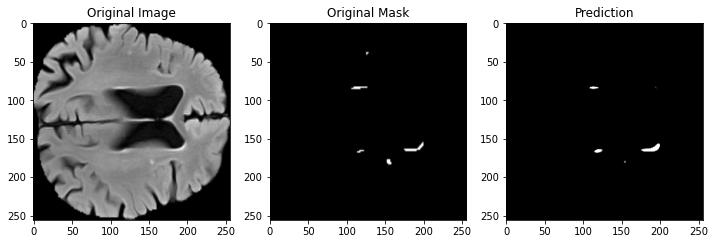

Slice ID: 359


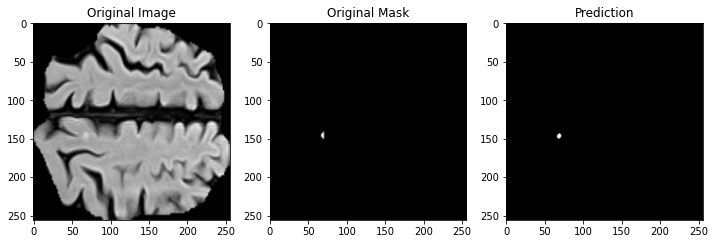

Slice ID: 191


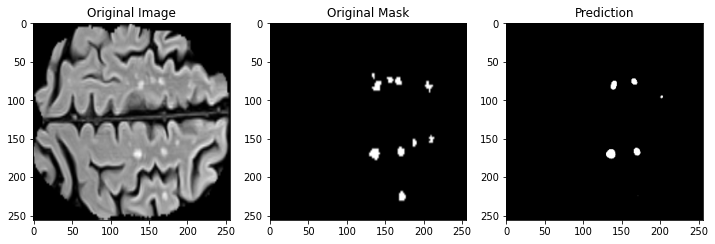

Slice ID: 176


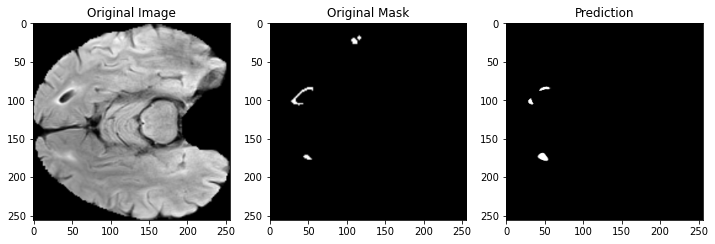

Slice ID: 364


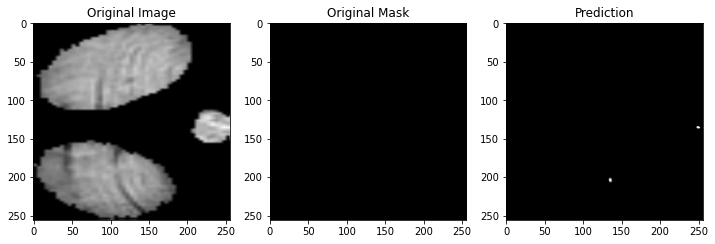

Slice ID: 77


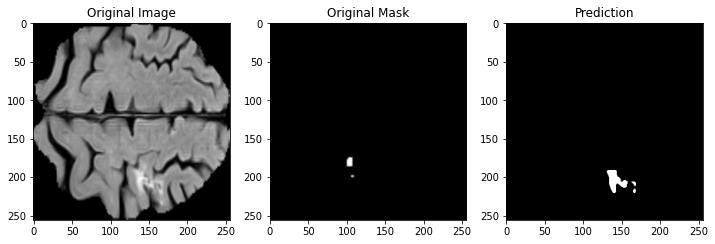

In [ ]:
pred_test = model.predict(imgs_test, verbose=1, batch_size=64)
for i in range(30):
    index=np.random.randint(len(imgs_test))
    print("Slice ID: " + str(index))
    img = rescale_intensity(imgs_test[index], out_range=(-1,1))
    
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(masks_test[index], cmap='gray')
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow((pred_test[index][:,:,0]), cmap='gray')
    plt.title('Prediction')
    plt.show()


# References

1. https://towardsdatascience.com/medical-images-segmentation-using-keras-7dc3be5a8524
2. https://github.com/jocicmarko/ultrasound-nerve-segmentation
3. https://github.com/FourierX9/wmh_ibbmTum
